# start

In [1]:
class Param: pass
param = Param()

#########################
param.PRFX = 'Mel0710A1'#
#########################

param.PRFX_B4 = None; param.FLD2USE_B4 = 0
param.PRFX_PREP = 'MelPrp0909A224' #MelPrp0909A224__fromMelPrp0628A1.ipynb
param.ARCH = 'efficientnet-b0'

from efficientnet_pytorch import EfficientNet
param.SZ = 224 #EfficientNet.get_image_size(param.ARCH) 

param.EPOCHS = 15

param.BS = 256
param.SEED = 101; 

param.K=5; 
param.FLDS2USE = range(param.K)
param.FP16 = True
param.PLTFACTOR=0.5; param.PATIENCE=5; param.MIN_LR=1e-8

param.USE_LAST_M_EPCS = 5

param.RandomResizedCrop_scale=(0.75, 1.0)
param.N_TTA = 8

param.LR=1e-3
param.WD=0

param.N_SAMPL = None

param.DEBUG = True
if param.DEBUG: 
    param.EPOCHS = 15
#     param.FLDS2USE = [0,1]
    param.N_SAMPL = 1024

DEVICE = 'cuda'; 
if DEVICE=='cpu': param.FP16 = False
PIN_MEM = (DEVICE=='cuda'); N_WORKERS=4

param.__dict__

{'PRFX': 'Mel0710A1',
 'PRFX_B4': None,
 'FLD2USE_B4': 0,
 'PRFX_PREP': 'MelPrp0909A224',
 'ARCH': 'efficientnet-b0',
 'SZ': 224,
 'EPOCHS': 15,
 'BS': 256,
 'SEED': 101,
 'K': 5,
 'FLDS2USE': range(0, 5),
 'FP16': True,
 'PLTFACTOR': 0.5,
 'PATIENCE': 5,
 'MIN_LR': 1e-08,
 'USE_LAST_M_EPCS': 5,
 'RandomResizedCrop_scale': (0.75, 1.0),
 'N_TTA': 8,
 'LR': 0.001,
 'WD': 0,
 'N_SAMPL': 1024,
 'DEBUG': True}

In [2]:
!nvidia-smi

Sat Jul 11 02:57:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   47C    P0    55W / 300W |     11MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# setup

In [3]:
from pathlib import Path
import pickle
import pandas as pd
import numpy as np
import random
import os, sys, gc
import datetime
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score as roc_auc

# https://github.com/eriklindernoren/PyTorch-YOLOv3/issues/162#issuecomment-491115265
from PIL import ImageFile; ImageFile.LOAD_TRUNCATED_IMAGES = True

def dtnow(): return datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

import torch
device=torch.device(DEVICE)
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler

from efficientnet_pytorch import EfficientNet
import cv2
import albumentations as A
from albumentations import pytorch as AT

from apex import amp

import warnings; warnings.filterwarnings("ignore")


def sigmoid(x): return 1 / (1 + np.exp(-x))

def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
set_seed(param.SEED)



p_out = f'../output/{param.PRFX}'; Path(p_out).mkdir(exist_ok=True,parents=True)
p_cmp = '../input/siim-isic-melanoma-classification'
if param.PRFX_B4 is not None: p_b4  = f'../output/{param.PRFX_B4}'


# prep

In [4]:
p_prp = f'../output/{param.PRFX_PREP}'
dftrn = pd.read_csv(f'{p_prp}/train_all_dedup.csv') 
print(dftrn.shape)

set_seed(param.SEED); dftrn = dftrn.sample(frac=1.)

if param.N_SAMPL is not None: dftrn = dftrn.head(param.N_SAMPL)
    
display(dftrn.head(2))
display(dftrn.shape)
display(dftrn.source.value_counts())
display(dftrn.groupby('source').target.mean())

(58032, 4)


,source,im_pth,patient_id,target
23539,20,../output/MelPrp0909A224/siim-isic-melanoma-cl...,IP_2618037,0.0
48725,19,../output/MelPrp0909A224/andrewmvd--isic-2019/...,BCN_0000529,0.0


(1024, 4)

20    557
19    467
Name: source, dtype: int64

source
19    0.164882
20    0.012567
Name: target, dtype: float64

## folds

In [5]:
idx_nopid=np.where(dftrn.patient_id.isna())[0]
print(len(idx_nopid))
dftrn['patient_id'].iloc[idx_nopid]=[f'Nan_{i}' for i in range(len(idx_nopid))]
assert dftrn.patient_id.isna().mean()==0

40


In [6]:
set_seed(param.SEED)
kf = GroupKFold(n_splits=param.K)
fld2trvl=list(kf.split(dftrn, groups=dftrn.patient_id))

for fld, (tr, vl) in enumerate(fld2trvl):
    print(fld, len(tr), len(vl))
    dftr=dftrn.iloc[tr]
    dfvl=dftrn.iloc[vl]
    assert set(dftr.patient_id)&set(dfvl.patient_id)==set()
for fld, (tr, vl) in enumerate(fld2trvl):
    dftr=dftrn.iloc[tr]
    display(dftr.target.value_counts()/len(tr))
for fld, (tr, vl) in enumerate(fld2trvl):
    dftr=dftrn.iloc[tr]
    display(dftr.source.value_counts())

0 819 205
1 819 205
2 819 205
3 819 205
4 820 204


0.0    0.912088
1.0    0.087912
Name: target, dtype: float64

0.0    0.918193
1.0    0.081807
Name: target, dtype: float64

0.0    0.919414
1.0    0.080586
Name: target, dtype: float64

0.0    0.924298
1.0    0.075702
Name: target, dtype: float64

0.0    0.915854
1.0    0.084146
Name: target, dtype: float64

20    451
19    368
Name: source, dtype: int64

20    445
19    374
Name: source, dtype: int64

20    440
19    379
Name: source, dtype: int64

20    447
19    372
Name: source, dtype: int64

20    445
19    375
Name: source, dtype: int64

In [7]:
display(dftrn.source.value_counts())
idx20 = np.where(dftrn.source==20)[0]
len(idx20)

20    557
19    467
Name: source, dtype: int64

557

In [8]:
fld2vl20 = []
for tr, vl in fld2trvl:
    vl20 = np.array([o for o in vl if o in idx20])
    print(len(vl), len(vl20))
    fld2vl20.append(vl20)

205 106
205 112
205 117
205 110
204 112


## testset

In [9]:
dftst = pd.read_csv(f'{p_prp}/test.csv', nrows=128 if param.DEBUG else None) 
display(dftst.head(3))

dfsub = pd.read_csv(f'{p_cmp}/sample_submission.csv', nrows=128 if param.DEBUG else None) 

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,im_pth
0,ISIC_0052060,IP_3579794,male,70.0,NaN,../output/MelPrp0909A224/siim-isic-melanoma-cl...
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,../output/MelPrp0909A224/siim-isic-melanoma-cl...
2,ISIC_0058510,IP_7960270,female,55.0,torso,../output/MelPrp0909A224/siim-isic-melanoma-cl...


# dataset

In [10]:
class MelDataset(Dataset):
    def __init__(self, df, mode='trn'):
        self.df = df
        self.mode = mode
        if mode=='trn':
            self.composed = A.Compose([
                A.RandomResizedCrop(param.SZ,param.SZ, scale=param.RandomResizedCrop_scale),
#                 A.Resize(param.SZ, param.SZ),
                A.Transpose(),
                A.Flip(),
                A.Rotate(360),
                A.OneOf([A.RandomBrightnessContrast(), A.CLAHE(),]),
#                 A.HueSaturationValue(
#                     hue_shift_limit=5,
#                     sat_shift_limit=5,
#                     p=1),
#                 A.OneOf([A.Blur(blur_limit=2), A.IAASharpen()]),
                A.Normalize(), 
                AT.ToTensor(),
            ])    
        else:
            self.composed = A.Compose([
                A.Resize(param.SZ, param.SZ),
                A.Normalize(),
                AT.ToTensor(),
            ])    
    def __getitem__(self, i):
        x = cv2.imread(self.df.im_pth.values[i]) 
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        x = self.composed(image=x)['image']
        if self.mode in ('trn', 'val'):
            y = self.df.target.values[i]
            return x, y
        else:
            return (x,)
    
    def __len__(self):
        return len(self.df)    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


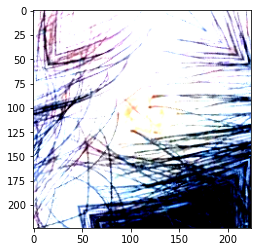

In [11]:
# better comment out A.Normalize() when showing 
if param.DEBUG:
    dstrn = MelDataset(dftrn, mode='trn')
    i = np.random.choice(len(dstrn))
    print(dstrn[i][0].shape)
    plt.imshow(dstrn[i][0].permute(1, 2, 0))

## test ds

In [12]:
dstst = MelDataset(dftst, mode='tst')
print(len(dstst))
dltst = DataLoader(dstst, batch_size=param.BS*2, shuffle=False, num_workers=N_WORKERS, pin_memory=PIN_MEM)
print(len(dltst))
lendl=len(dltst)

128
1


# model

In [13]:
def mkmdl():  
    mdl = EfficientNet.from_pretrained(param.ARCH, num_classes=1)
    return mdl

In [14]:
# mdl = mkmdl()

## focal loss

In [15]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=3, logits=True, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduce=False)
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduce=False)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

def loss_fn(outputs, targets):
    return FocalLoss()(outputs, targets.view(-1, 1))

# train

## TTA

In [16]:
# def evaluate(model, dl):
#     model.eval()
#     prd = []
#     y = []
#     for step, dat in enumerate(dl):
#         xb, yb = (o.to(device) for o in dat)
#         with torch.no_grad(): prdb = model(xb)
#         prd.append(prdb.cpu().detach().numpy())
#         y.append(yb.cpu().detach().numpy())
#     prd = np.concatenate(prd)    
#     y = np.concatenate(y)    
#     lss = F.binary_cross_entropy_with_logits(torch.tensor(prd),torch.tensor(y).unsqueeze(1)).item()
#     scr = roc_auc(y, prd)
#     return lss, scr, y, prd

In [17]:
# Diheral TTA outside dataloader
def get_trans(img, I):
    if I >= 4:
        img = img.transpose(2,3)
    if I % 4 == 0:
        return img
    elif I % 4 == 1:
        return img.flip(2)
    elif I % 4 == 2:
        return img.flip(3)
    elif I % 4 == 3:
        return img.flip(2).flip(3)

In [18]:
def evaluate(model, dl):
    model.eval()
    prd = []
    y = []   
    for step, dat in enumerate(dl):
        xb, yb = (o.to(device) for o in dat)
        y.append(yb.cpu().detach().numpy())
        with torch.no_grad(): 
            for I in range(param.N_TTA):
                if I==0: 
                    prdb = model(get_trans(xb, I))
                else:
                    prdb += model(get_trans(xb, I))    
        prd.append((prdb/param.N_TTA).cpu().detach().numpy())
    prd = np.concatenate(prd)    
    y = np.concatenate(y)    
    lss = F.binary_cross_entropy_with_logits(torch.tensor(prd),torch.tensor(y).unsqueeze(1)).item()
    scr = roc_auc(y, prd)
    return lss, scr, y, prd

## infer

In [19]:
def infer(model, dl):
    lendl=len(dl)
    model.eval()
    prd = []
    for step, dat in enumerate(dl):
        if step%1000==0: print(dtnow(), f'step {step}/{lendl}')
        xb=dat[0].to(device)
        with torch.no_grad(): 
            for I in range(param.N_TTA):
                if I==0: 
                    prdb = model(get_trans(xb, I))
                else:
                    prdb += model(get_trans(xb, I))    
        prd.append((prdb/param.N_TTA).cpu().detach().numpy())
    prd = np.concatenate(prd)    

    return prd

## set up data

In [20]:
def getdls(fld):
    tr,vl=fld2trvl[fld]
    vl20 =fld2vl20[fld]
    assert set(vl20) < set(vl)
    dftr=dftrn.iloc[tr]
    dfvl=dftrn.iloc[vl]
    dfvl20=dftrn.iloc[vl20]
    ystr=dftr.target.values
    ysvl=dfvl.target.values
    ysvl20=dfvl20.target.values
    dstr = MelDataset(dftr, mode='trn')
    dsvl = MelDataset(dfvl, mode='val')
    dsvl20 = MelDataset(dfvl20, mode='val')
    dltr = DataLoader(dstr, batch_size=param.BS,       shuffle=True,  num_workers=N_WORKERS, pin_memory=PIN_MEM)
    dlvl = DataLoader(dsvl, batch_size=param.BS*2,     shuffle=False, num_workers=N_WORKERS, pin_memory=PIN_MEM)
    dlvl20 = DataLoader(dsvl20, batch_size=param.BS*2, shuffle=False, num_workers=N_WORKERS, pin_memory=PIN_MEM)
    lendl=len(dltr)    
    return dltr,dlvl,dlvl20

## run train

In [21]:
set_seed(param.SEED)

results = {}
results['fld2stats']={}

for fld in param.FLDS2USE:

    mdl = mkmdl().to(device)
    if param.PRFX_B4 is not None: 
        fnm_mdl_b4 = f'{p_b4}/model_{param.PRFX_B4}_fld_{param.fld}_best.p'
        print('load previously trained', fnm_mdl_b4)
        mdl.load_state_dict(torch.load(fnm_mdl_b4, map_location=torch.device(DEVICE)))
    # opt = optim.SGD(mdl.parameters(), lr=param.LR, momentum=param.MOMENTUM, weight_decay=param.WD)
    opt = optim.Adam(mdl.parameters(), lr=param.LR, weight_decay=param.WD)
    schdl = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='max', factor=param.PLTFACTOR, patience=param.PATIENCE, min_lr=param.MIN_LR, verbose=True)
    if param.FP16: mdl, opt = amp.initialize(mdl, opt, opt_level='O1', verbosity=0)
    mdl.zero_grad()

        
    tr,vl=fld2trvl[fld]
    dltr,dlvl,dlvl20=getdls(fld)
    print(f'fld:{fld};', 'dltr,dlvl,dlvl20:', len(dltr), len(dlvl),len(dlvl20))
    

    stats = {
    'lss': {'tr':[],'vl':[],'vl20':[]},
    'scr': {'tr':[],'vl':[],'vl20':[]},
    }
    ep2oof = []

    best_scr = float('-inf')
    best_epc = -1
    best_scr20 = float('-inf')
    best_epc20 = -1
    
    
    for epc in range(param.EPOCHS):
        prdtr_ep=[]
        ytr_ep=[]
        for step, dat in enumerate(dltr):
            mdl.train()
            xb,yb=(o.to(device) for o in dat)
            yb = yb.unsqueeze(1)
            prdb = mdl(xb)
    #         loss = F.binary_cross_entropy_with_logits(prdb, yb)
            loss =  loss_fn(prdb,yb)
            if param.FP16:
                with amp.scale_loss(loss, opt) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()
            if param.FP16:
                torch.nn.utils.clip_grad_norm_(amp.master_params(opt), 1)
            else:
                torch.nn.utils.clip_grad_norm_(mdl.parameters(), 1)
            opt.step()
            opt.zero_grad()
            prdtr_ep.append(prdb.cpu().detach().numpy())
            ytr_ep.append(yb.cpu().detach().numpy())
            if step>0 and step%1000==0: print(dtnow(), f'ep {epc} step {step}/{lendl}')

        prdtr_ep = np.concatenate(prdtr_ep)
        ytr_ep = np.concatenate(ytr_ep)    
        lss_tr_ep = F.binary_cross_entropy_with_logits(torch.tensor(prdtr_ep),torch.tensor(ytr_ep)).item()
        scr_tr_ep = roc_auc(ytr_ep, prdtr_ep)
        stats['lss']['tr'].append(lss_tr_ep)
        stats['scr']['tr'].append(scr_tr_ep)

        lss_vl_ep, scr_vl_ep, yvl_ep, prdvl_ep = evaluate(mdl, dlvl)
        stats['lss']['vl'].append(lss_vl_ep)
        stats['scr']['vl'].append(scr_vl_ep)
        ep2oof.append(prdvl_ep)

        lss_vl20_ep, scr_vl20_ep, yvl20_ep, prdvl20_ep = evaluate(mdl, dlvl20)
        stats['lss']['vl20'].append(lss_vl20_ep)
        stats['scr']['vl20'].append(scr_vl20_ep)

        print(dtnow(), f'fld {fld} ep {epc}: lss_tr {lss_tr_ep:.3f}; lss_vl {lss_vl_ep:.3f}; lss_vl20 {lss_vl20_ep:.3f}; scr_tr {scr_tr_ep:.3f}; scr_vl {scr_vl_ep:.3f}; scr_vl20 {scr_vl20_ep:.3f}; ')

        if epc> (10 if not param.DEBUG else -1):
            prdtst = infer(mdl, dltst)
            dfsub.target = sigmoid(prdtst)
            dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_epc_{epc}.csv', index=False)
            torch.save(mdl.state_dict(), f'{p_out}/model_{param.PRFX}_fld_{fld}_epc_{epc}.p')

        if scr_vl_ep>best_scr:
            print(f'better scr {best_scr:.3f} -> {scr_vl_ep:.3f}')
            best_scr = scr_vl_ep
            best_epc = epc
            torch.save(mdl.state_dict(), f'{p_out}/model_{param.PRFX}_fld_{fld}_best.p')
            dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_best.csv', index=False)

        if scr_vl20_ep>best_scr20:
            print(f'better scr20 {best_scr20:.3f} -> {scr_vl20_ep:.3f}')
            best_scr20 = scr_vl20_ep
            best_epc20 = epc
            torch.save(mdl.state_dict(), f'{p_out}/model_{param.PRFX}_fld_{fld}_best20.p')
            dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_best20.csv', index=False)

        schdl.step(scr_vl_ep)  # Update learning rate schedule
        
        stats['best_scr'] = best_scr
        stats['best_epc'] = best_epc
        stats['best_scr20'] = best_scr20
        stats['best_epc20'] = best_epc20
        results['fld2stats'][fld] = stats
        pickle.dump(results, open(f'{p_out}/results_{param.PRFX}.p', 'wb'))  
    pickle.dump(ep2oof, open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'wb'))  

Loaded pretrained weights for efficientnet-b0
fld:0; dltr,dlvl,dlvl20: 4 1 1
2020-07-11 02:58:04 fld 0 ep 0: lss_tr 0.585; lss_vl 0.539; lss_vl20 0.518; scr_tr 0.517; scr_vl 0.646; scr_vl20 0.314; 
2020-07-11 02:58:04 step 0/1
better scr -inf -> 0.646
better scr20 -inf -> 0.314
2020-07-11 02:58:10 fld 0 ep 1: lss_tr 0.386; lss_vl 0.318; lss_vl20 0.235; scr_tr 0.849; scr_vl 0.678; scr_vl20 0.486; 
2020-07-11 02:58:11 step 0/1
better scr 0.646 -> 0.678
better scr20 0.314 -> 0.486
2020-07-11 02:58:17 fld 0 ep 2: lss_tr 0.315; lss_vl 0.216; lss_vl20 0.108; scr_tr 0.898; scr_vl 0.693; scr_vl20 0.424; 
2020-07-11 02:58:18 step 0/1
better scr 0.678 -> 0.693
2020-07-11 02:58:24 fld 0 ep 3: lss_tr 0.308; lss_vl 0.214; lss_vl20 0.092; scr_tr 0.910; scr_vl 0.717; scr_vl20 0.152; 
2020-07-11 02:58:24 step 0/1
better scr 0.693 -> 0.717
2020-07-11 02:58:30 fld 0 ep 4: lss_tr 0.297; lss_vl 0.201; lss_vl20 0.104; scr_tr 0.941; scr_vl 0.745; scr_vl20 0.133; 
2020-07-11 02:58:31 step 0/1
better scr 0.71

2020-07-11 03:03:08 fld 3 ep 0: lss_tr 0.608; lss_vl 0.547; lss_vl20 0.516; scr_tr 0.484; scr_vl 0.632; scr_vl20 0.624; 
2020-07-11 03:03:08 step 0/1
better scr -inf -> 0.632
better scr20 -inf -> 0.624
2020-07-11 03:03:15 fld 3 ep 1: lss_tr 0.363; lss_vl 0.318; lss_vl20 0.199; scr_tr 0.769; scr_vl 0.791; scr_vl20 0.853; 
2020-07-11 03:03:15 step 0/1
better scr 0.632 -> 0.791
better scr20 0.624 -> 0.853
2020-07-11 03:03:22 fld 3 ep 2: lss_tr 0.346; lss_vl 0.302; lss_vl20 0.133; scr_tr 0.870; scr_vl 0.779; scr_vl20 0.844; 
2020-07-11 03:03:22 step 0/1
2020-07-11 03:03:28 fld 3 ep 3: lss_tr 0.305; lss_vl 0.324; lss_vl20 0.089; scr_tr 0.936; scr_vl 0.771; scr_vl20 0.835; 
2020-07-11 03:03:29 step 0/1
2020-07-11 03:03:35 fld 3 ep 4: lss_tr 0.280; lss_vl 0.395; lss_vl20 0.062; scr_tr 0.936; scr_vl 0.753; scr_vl20 0.853; 
2020-07-11 03:03:36 step 0/1
2020-07-11 03:03:42 fld 3 ep 5: lss_tr 0.245; lss_vl 0.400; lss_vl20 0.051; scr_tr 0.961; scr_vl 0.709; scr_vl20 0.945; 
2020-07-11 03:03:43 ste

# training trajec

In [22]:
results['fld2trvl'] = fld2trvl
results['fld2vl20'] = fld2vl20
results['param'] = param
pickle.dump(results, open(f'{p_out}/results_{param.PRFX}.p', 'wb'))  

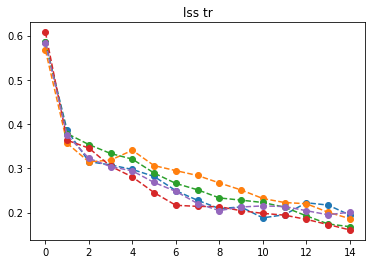

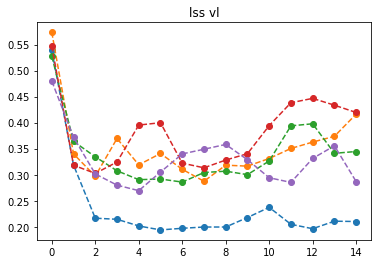

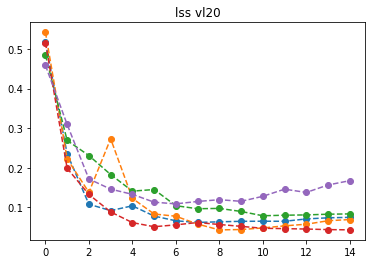

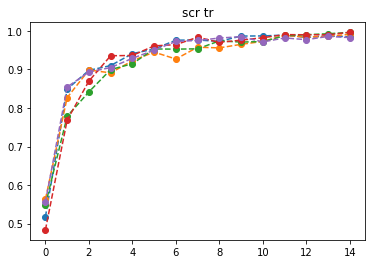

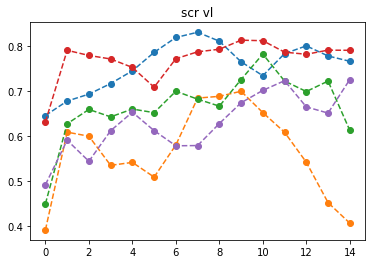

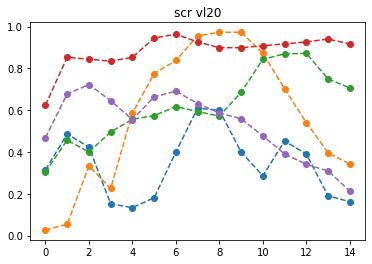

In [23]:
for mtrc in ['lss', 'scr']:
    for k in ['tr','vl','vl20']:
        plt.title(f'{mtrc} {k}')
        for fld in param.FLDS2USE:
            plt.plot(results['fld2stats'][fld][mtrc][k], 'o--')
        plt.show()

# oofs

In [24]:
vls = []
for fld in param.FLDS2USE:
    _,vl=fld2trvl[fld]
    vls += list(vl)
len(vls), vls[:10]

(1024, [1, 11, 21, 25, 41, 63, 66, 67, 70, 73])

## only last epoch

In [25]:
oofs = []
for fld in param.FLDS2USE:
    ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
    ep2oof = np.concatenate(ep2oof,1)
    oof = list(ep2oof[:,-1])
    oofs += list(oof)
    
roc_auc(dftrn.target.iloc[vls], oofs)

0.6598024316109423

## only best_scr epoch

In [26]:
oofs = []
for fld in param.FLDS2USE:
    ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
    ep2oof = np.concatenate(ep2oof,1)
    best_epc = results['fld2stats'][fld]['best_epc']
    oof = list(ep2oof[:,best_epc])
    oofs += list(oof)
roc_auc(dftrn.target.iloc[vls], oofs)

0.7643996960486322

## avg all epochs

In [27]:
oofs = []
for fld in param.FLDS2USE:
    ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
    ep2oof = np.concatenate(ep2oof,1)
    oof = list(ep2oof.mean(1))
    oofs += list(oof)
roc_auc(dftrn.target.iloc[vls], oofs)

0.7122593718338399

## avg last m epochs

In [28]:
oofs = []
for fld in param.FLDS2USE:
    ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
    ep2oof = np.concatenate(ep2oof,1)
    oof = list(ep2oof[:, -3:].mean(1))
    oofs += list(oof)
roc_auc(dftrn.target.iloc[vls], oofs)

0.6762601317122594

In [29]:
def get_oof_avg_last_m(m):
    oofs = []
    for fld in param.FLDS2USE:
        ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
        ep2oof = np.concatenate(ep2oof,1)
        oof = list(ep2oof[:, -m:].mean(1))
        oofs += list(oof)
    return oofs

In [30]:
for m in range(1, 5):
    oofs = get_oof_avg_last_m(m)
    print(m, roc_auc(dftrn.target.iloc[vls], oofs))

1 0.6598024316109423
2 0.667565856129686
3 0.6762601317122594
4 0.6878926038500508


## avg last m epochs before epo-q

In [31]:
def get_oof_avg_last_m_before_q(m,q):
    oofs = []
    for fld in param.FLDS2USE:
        ep2oof = pickle.load(open(f'{p_out}/ep2oof_{param.PRFX}_fld_{fld}.p', 'rb'))
        ep2oof = np.concatenate(ep2oof,1)
        oof = list(ep2oof[:, q-m:q].mean(1))
        oofs += list(oof)
    return oofs

In [32]:
for m in range(1, 5):
    oofs = get_oof_avg_last_m_before_q(m, 10)
    print(m, roc_auc(dftrn.target.iloc[vls], oofs))

1 0.728710739614995
2 0.7152862208713273
3 0.7111258865248227
4 0.7044262917933131


# submissions

## only last epoch

In [33]:
lst_sub = []
for fld in param.FLDS2USE:
    sub_fld = pd.read_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_epc_{param.EPOCHS-1}.csv') 
    print('fld', fld, sub_fld.target.mean())
    display(sub_fld.head(3))
    lst_sub.append(sub_fld.target.values)

fld 0 0.02433591277007812


,image_name,target
0,ISIC_0052060,0.002511
1,ISIC_0052349,0.001507
2,ISIC_0058510,0.014504


fld 1 0.018355285508437506


,image_name,target
0,ISIC_0052060,0.018761
1,ISIC_0052349,0.008779
2,ISIC_0058510,0.028114


fld 2 0.02270086495546874


,image_name,target
0,ISIC_0052060,0.005843
1,ISIC_0052349,0.016153
2,ISIC_0058510,0.002269


fld 3 0.012730240301875001


,image_name,target
0,ISIC_0052060,0.004281
1,ISIC_0052349,0.000685
2,ISIC_0058510,0.000944


fld 4 0.039906260960781245


,image_name,target
0,ISIC_0052060,0.001274
1,ISIC_0052349,0.075721
2,ISIC_0058510,0.002011


0.023605712899328127


,image_name,target
0,ISIC_0052060,0.006534
1,ISIC_0052349,0.020569
2,ISIC_0058510,0.009568


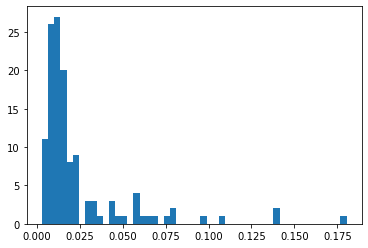

In [34]:
sub = np.mean(lst_sub,0)
print(sub.mean())
dfsub.target = sub
display(dfsub.head(3))
plt.hist(dfsub.target, bins=50);

In [35]:
dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_onlylast.csv', index=False)

## only best_scr epoch

In [36]:
lst_sub = []
for fld in param.FLDS2USE:
    sub_fld = pd.read_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_best.csv') 
    print('fld', fld, sub_fld.target.mean())
    display(sub_fld.head(3))
    lst_sub.append(sub_fld.target.values)

fld 0 0.024203356874999995


,image_name,target
0,ISIC_0052060,0.003377
1,ISIC_0052349,0.006615
2,ISIC_0058510,0.005364


fld 1 0.022144390596874997


,image_name,target
0,ISIC_0052060,0.018125
1,ISIC_0052349,0.005180
2,ISIC_0058510,0.008252


fld 2 0.017669995981250006


,image_name,target
0,ISIC_0052060,0.003538
1,ISIC_0052349,0.007461
2,ISIC_0058510,0.003795


fld 3 0.023080559446093742


,image_name,target
0,ISIC_0052060,0.003976
1,ISIC_0052349,0.003900
2,ISIC_0058510,0.002332


fld 4 0.039906260960781245


,image_name,target
0,ISIC_0052060,0.001274
1,ISIC_0052349,0.075721
2,ISIC_0058510,0.002011


0.025400912772


,image_name,target
0,ISIC_0052060,0.006058
1,ISIC_0052349,0.019775
2,ISIC_0058510,0.004351


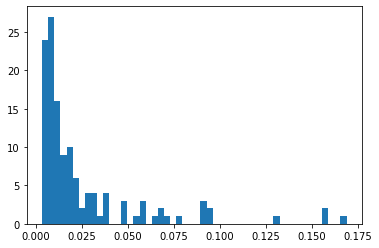

In [37]:
sub = np.mean(lst_sub,0)
print(sub.mean())
dfsub.target = sub
display(dfsub.head(3))
plt.hist(dfsub.target, bins=50);

In [38]:
dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_onlybestscr.csv', index=False)

## avg last m epochs

In [39]:
m = 2

In [40]:
lst_sub = []
for fld in param.FLDS2USE:
    for epc in range(param.EPOCHS-m, param.EPOCHS):
        sub_fld = pd.read_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_epc_{epc}.csv') 
        print('fld', fld, 'epc', epc, sub_fld.target.mean())
        display(sub_fld.head(3))
        lst_sub.append(sub_fld.target.values)

fld 0 epc 13 0.021410866675546876


,image_name,target
0,ISIC_0052060,0.001372
1,ISIC_0052349,0.000883
2,ISIC_0058510,0.011464


fld 0 epc 14 0.02433591277007812


,image_name,target
0,ISIC_0052060,0.002511
1,ISIC_0052349,0.001507
2,ISIC_0058510,0.014504


fld 1 epc 13 0.02350792371953124


,image_name,target
0,ISIC_0052060,0.022716
1,ISIC_0052349,0.007969
2,ISIC_0058510,0.032961


fld 1 epc 14 0.018355285508437506


,image_name,target
0,ISIC_0052060,0.018761
1,ISIC_0052349,0.008779
2,ISIC_0058510,0.028114


fld 2 epc 13 0.016403437219531244


,image_name,target
0,ISIC_0052060,0.003299
1,ISIC_0052349,0.012576
2,ISIC_0058510,0.002149


fld 2 epc 14 0.02270086495546874


,image_name,target
0,ISIC_0052060,0.005843
1,ISIC_0052349,0.016153
2,ISIC_0058510,0.002269


fld 3 epc 13 0.012045748045624994


,image_name,target
0,ISIC_0052060,0.004867
1,ISIC_0052349,0.000629
2,ISIC_0058510,0.000981


fld 3 epc 14 0.012730240301875001


,image_name,target
0,ISIC_0052060,0.004281
1,ISIC_0052349,0.000685
2,ISIC_0058510,0.000944


fld 4 epc 13 0.03282579097004686


,image_name,target
0,ISIC_0052060,0.001490
1,ISIC_0052349,0.018476
2,ISIC_0058510,0.000947


fld 4 epc 14 0.039906260960781245


,image_name,target
0,ISIC_0052060,0.001274
1,ISIC_0052349,0.075721
2,ISIC_0058510,0.002011


0.02242223311269219


,image_name,target
0,ISIC_0052060,0.006641
1,ISIC_0052349,0.014338
2,ISIC_0058510,0.009634


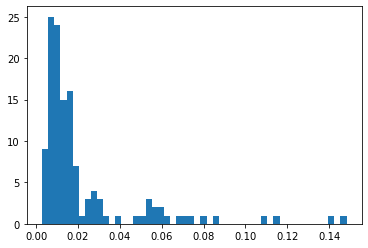

In [41]:
sub = np.mean(lst_sub,0)
print(sub.mean())
dfsub.target = sub
display(dfsub.head(3))
plt.hist(dfsub.target, bins=50);

In [42]:
dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_avglast{m}.csv', index=False)

## avg last m epochs before epo-q

In [43]:
m = 3
q = 10

In [44]:
lst_sub = []
for fld in param.FLDS2USE:
    for epc in range(q-m, q):
        sub_fld = pd.read_csv(f'{p_out}/submission_{param.PRFX}_fld_{fld}_epc_{epc}.csv') 
        print('fld', fld, 'epc', epc, sub_fld.target.mean())
        display(sub_fld.head(3))
        lst_sub.append(sub_fld.target.values)

fld 0 epc 7 0.024203356874999995


,image_name,target
0,ISIC_0052060,0.003377
1,ISIC_0052349,0.006615
2,ISIC_0058510,0.005364


fld 0 epc 8 0.026969346801562502


,image_name,target
0,ISIC_0052060,0.003160
1,ISIC_0052349,0.006121
2,ISIC_0058510,0.015365


fld 0 epc 9 0.022147958837499992


,image_name,target
0,ISIC_0052060,0.002341
1,ISIC_0052349,0.003483
2,ISIC_0058510,0.022890


fld 1 epc 7 0.045393102790625


,image_name,target
0,ISIC_0052060,0.032101
1,ISIC_0052349,0.012384
2,ISIC_0058510,0.009055


fld 1 epc 8 0.023384535114843737


,image_name,target
0,ISIC_0052060,0.017917
1,ISIC_0052349,0.004792
2,ISIC_0058510,0.004867


fld 1 epc 9 0.022144390596874997


,image_name,target
0,ISIC_0052060,0.018125
1,ISIC_0052349,0.005180
2,ISIC_0058510,0.008252


fld 2 epc 7 0.04256190237031251


,image_name,target
0,ISIC_0052060,0.018405
1,ISIC_0052349,0.012528
2,ISIC_0058510,0.020410


fld 2 epc 8 0.04383498993437499


,image_name,target
0,ISIC_0052060,0.017243
1,ISIC_0052349,0.018942
2,ISIC_0058510,0.023735


fld 2 epc 9 0.0359203905828125


,image_name,target
0,ISIC_0052060,0.010249
1,ISIC_0052349,0.021948
2,ISIC_0058510,0.015015


fld 3 epc 7 0.04064838475703127


,image_name,target
0,ISIC_0052060,0.002652
1,ISIC_0052349,0.015015
2,ISIC_0058510,0.006074


fld 3 epc 8 0.031108730365625


,image_name,target
0,ISIC_0052060,0.003524
1,ISIC_0052349,0.008544
2,ISIC_0058510,0.004023


fld 3 epc 9 0.023080559446093742


,image_name,target
0,ISIC_0052060,0.003976
1,ISIC_0052349,0.003900
2,ISIC_0058510,0.002332


fld 4 epc 7 0.039242204474062486


,image_name,target
0,ISIC_0052060,0.002652
1,ISIC_0052349,0.012384
2,ISIC_0058510,0.012576


fld 4 epc 8 0.02909028258257813


,image_name,target
0,ISIC_0052060,0.000656
1,ISIC_0052349,0.016277
2,ISIC_0058510,0.005957


fld 4 epc 9 0.02581575156460937


,image_name,target
0,ISIC_0052060,0.000333
1,ISIC_0052349,0.045607
2,ISIC_0058510,0.004830


0.031703059139593745


,image_name,target
0,ISIC_0052060,0.009114
1,ISIC_0052349,0.012915
2,ISIC_0058510,0.010716


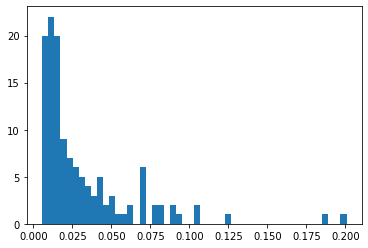

In [45]:
sub = np.mean(lst_sub,0)
print(sub.mean())
dfsub.target = sub
display(dfsub.head(3))
plt.hist(dfsub.target, bins=50);

In [46]:
dfsub.to_csv(f'{p_out}/submission_{param.PRFX}_{m}before{q}.csv', index=False)

# fin

In [47]:
param.__dict__

{'PRFX': 'Mel0710A1',
 'PRFX_B4': None,
 'FLD2USE_B4': 0,
 'PRFX_PREP': 'MelPrp0909A224',
 'ARCH': 'efficientnet-b0',
 'SZ': 224,
 'EPOCHS': 15,
 'BS': 256,
 'SEED': 101,
 'K': 5,
 'FLDS2USE': range(0, 5),
 'FP16': True,
 'PLTFACTOR': 0.5,
 'PATIENCE': 5,
 'MIN_LR': 1e-08,
 'USE_LAST_M_EPCS': 5,
 'RandomResizedCrop_scale': (0.75, 1.0),
 'N_TTA': 8,
 'LR': 0.001,
 'WD': 0,
 'N_SAMPL': 1024,
 'DEBUG': True}

In [48]:
!nvidia-smi

Sat Jul 11 03:06:32 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.100      Driver Version: 440.100      CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   54C    P0    48W / 300W |  14324MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  